# Statistics Group 12 - Final Project

### Data Structure
A dataset containing 1311 entries on 6 variables, for 57 countries over 23 years. The variables are as follows:

- **Year**: The year of observation
- **GDP Growth**: Annual GDP growth rate
- **GFCF change**: Gross Fixed Capital Formation change
- **Inflation change**: Percentage change in inflation
- **Unemployment change**: Percentage change in unemployment (some entries may have null values)

### Objective 
Predict the GDP growth rate with the other variables as predictors.

In [245]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

# For modeling
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

# Import OLS 
import statsmodels.api as sm

# Import data
data = pd.read_csv('../Data/economic_indicators.csv', index_col=0)

#### Check correlations

In [246]:
data_explore = data.drop('Year', axis=1)
data_explore.corr().style.background_gradient(cmap='coolwarm')

,GDP Growth,GFCF change,Inflation change,Unemployment change
GDP Growth,1.000000,0.583332,-0.086875,-0.386171
GFCF change,0.583332,1.000000,0.135399,-0.346725
Inflation change,-0.086875,0.135399,1.000000,-0.047444
Unemployment change,-0.386171,-0.346725,-0.047444,1.000000


#### Check VIF

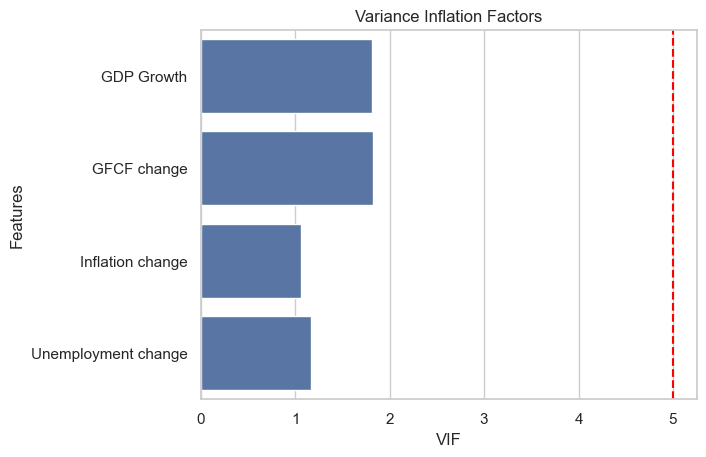

In [247]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the VIF with confidence intervals
variables = data_explore
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.round(1)

# Plot the VIF
sns.set(style="whitegrid")
ax = sns.barplot(x="VIF", y="Features", data=vif)
# Add a line on 5
plt.axvline(x=5, color='red', linestyle='--')
plt.title('Variance Inflation Factors')
plt.show()

#### Check for interactions with the target variable

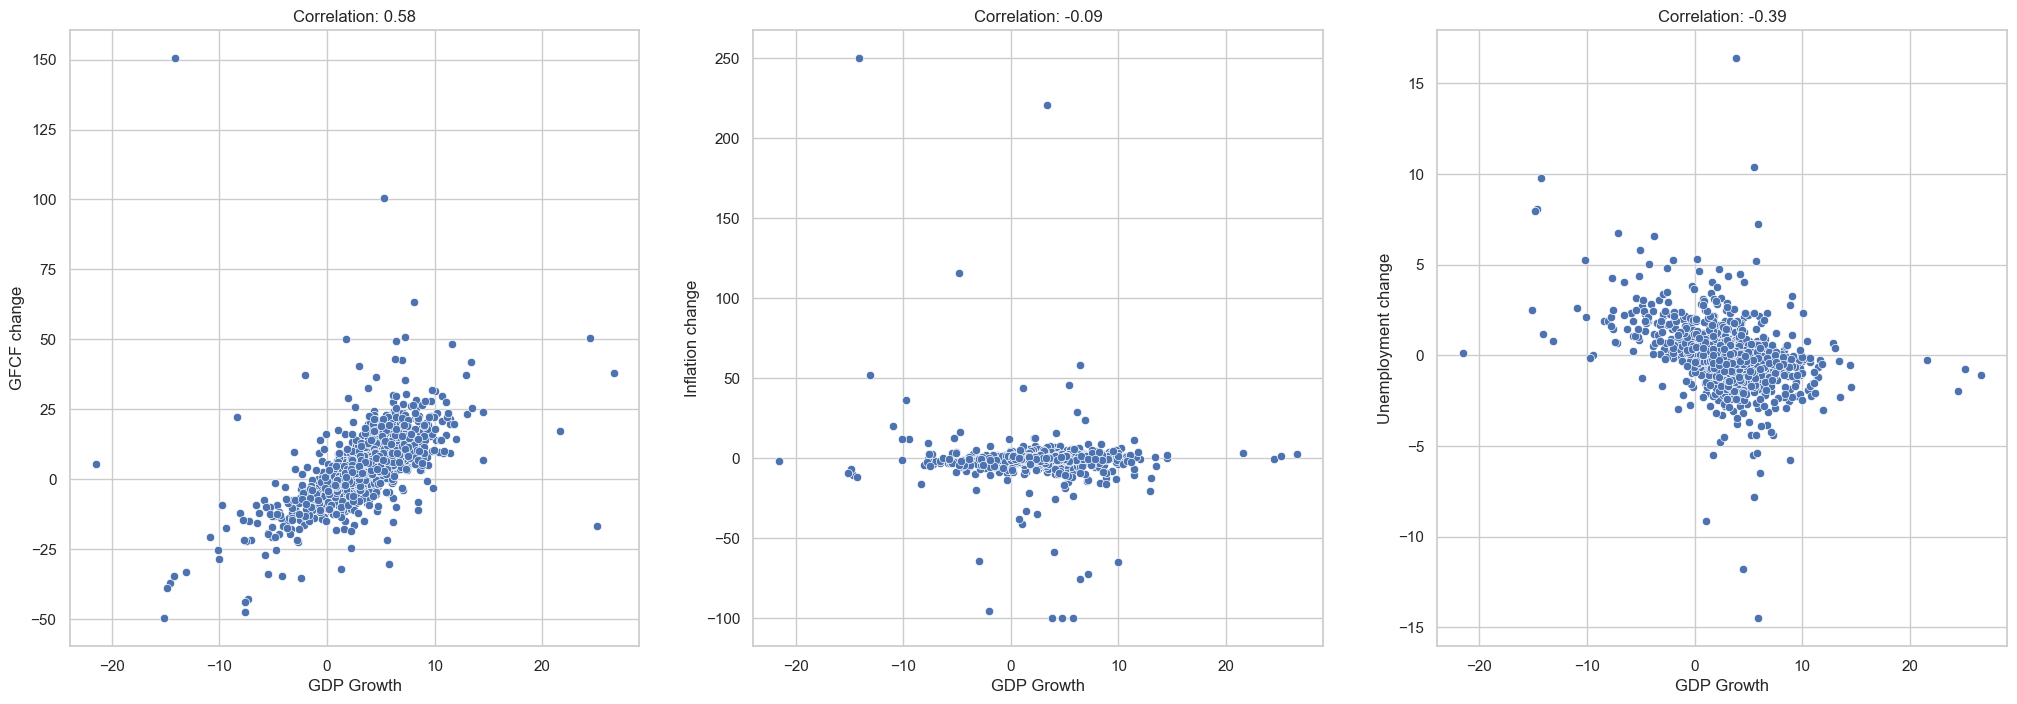

In [248]:
data_explore['Country'] = data.index

# Plot scatterplots of the variables against the GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GDP Growth", y="GFCF change", data=data_explore, ax=axs[0])
sns.scatterplot(x="GDP Growth", y="Inflation change", data=data_explore, ax=axs[1])
sns.scatterplot(x="GDP Growth", y="Unemployment change", data=data_explore, ax=axs[2])
corrs = data_explore.drop('Country', axis=1).corr().round(2)
for i in range(len(axs)):
    axs[i].set_title('Correlation: ' + str(corrs.iloc[0, i+1]))
    axs[i].set_xlabel('GDP Growth')
plt.show()

We are not convienced with the results, especially as we know that inflation has a positive relationship with GDP growth

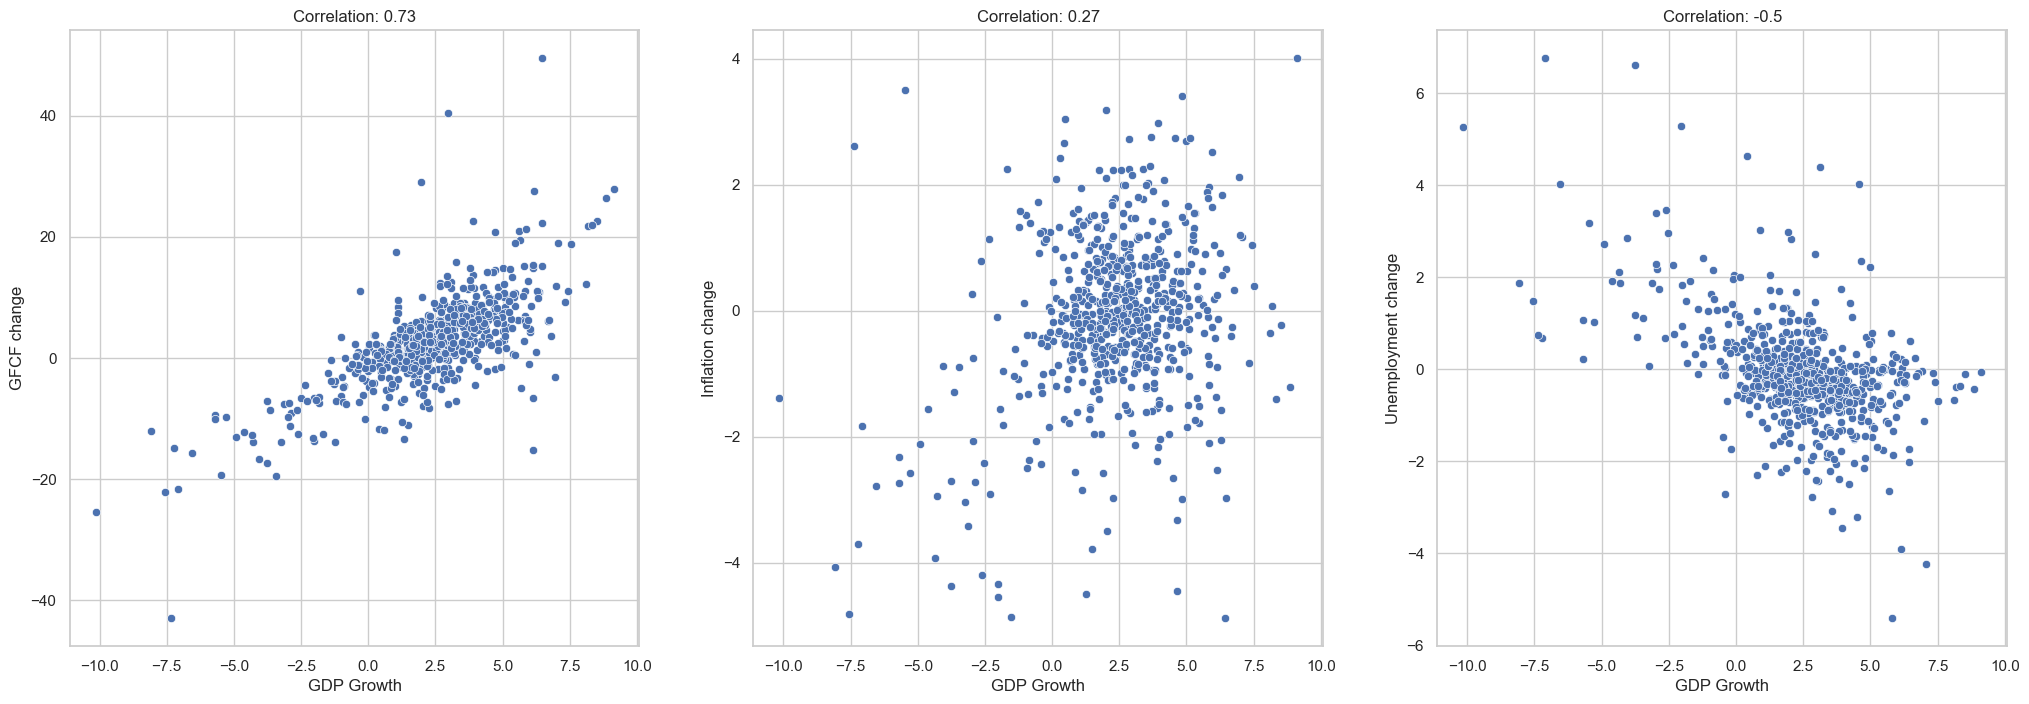

In [304]:
# Lets cap the inflation at -5, 5
countries_more_than_10 = data[np.abs(data['Inflation change']) > 5].index.unique()
data_inf_capped = data.drop(countries_more_than_10, axis=0)

# Plot scatterplots of the variables against the GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GDP Growth", y="GFCF change", data=data_inf_capped, ax=axs[0])
sns.scatterplot(x="GDP Growth", y="Inflation change", data=data_inf_capped, ax=axs[1])
sns.scatterplot(x="GDP Growth", y="Unemployment change", data=data_inf_capped, ax=axs[2])
corrs = data_inf_capped.drop('Year', axis=1).corr().round(2)

for i in range(len(axs)):
    axs[i].set_title('Correlation: ' + str(corrs.iloc[0, i+1]))
    axs[i].set_xlabel('GDP Growth')
plt.show()

## Pooled OLS

In [305]:
X = data_inf_capped[['GFCF change','Unemployment change', 'Inflation change']]
y = data_inf_capped['GDP Growth']

# Add constant to X
X = sm.add_constant(X)

# Fit OLS
pooled_ols = sm.OLS(y, X).fit() 

# Print summary table
print(pooled_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     280.8
Date:                Sat, 13 Jan 2024   Prob (F-statistic):          2.84e-116
Time:                        17:13:25   Log-Likelihood:                -1225.3
No. Observations:                 644   AIC:                             2459.
Df Residuals:                     640   BIC:                             2477.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.7631    

#### Are residuals normally distributed?


- Looking at the Jarque-Bera and omnibus tests, we have non normality in the residuals
- This doesnt mean that the estimator isnt the BLUE (!)

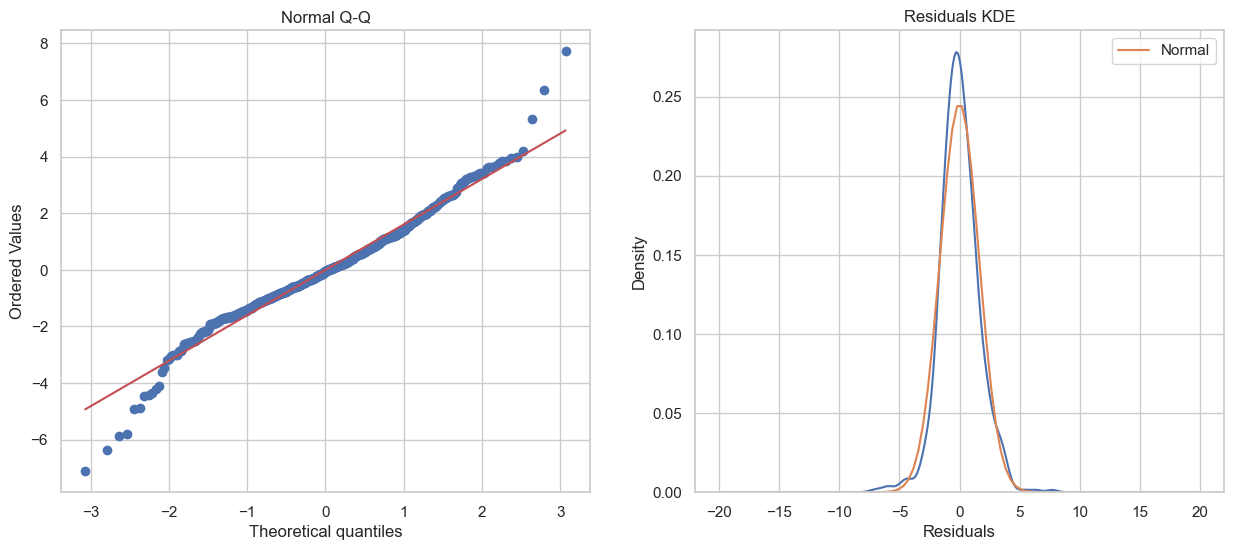

In [306]:
# Lets look at the Q-Q plot of the residuals
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
_, (__, ___, r) = st.probplot(pooled_ols.resid, plot=ax[0], fit=True)


sns.kdeplot(pooled_ols.resid, ax=ax[1])

# Estimate the normal distribution
mean, std = st.norm.fit(pooled_ols.resid)
ax[1].plot(np.linspace(-20,20,100), st.norm.pdf(np.linspace(-20,20,100), mean, std), label='Normal')
ax[1].legend()
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Density')
ax[1].set_title('Residuals KDE')
ax[0].set_title('Normal Q-Q')
plt.show()

#### Are the residuals homoskedastic?

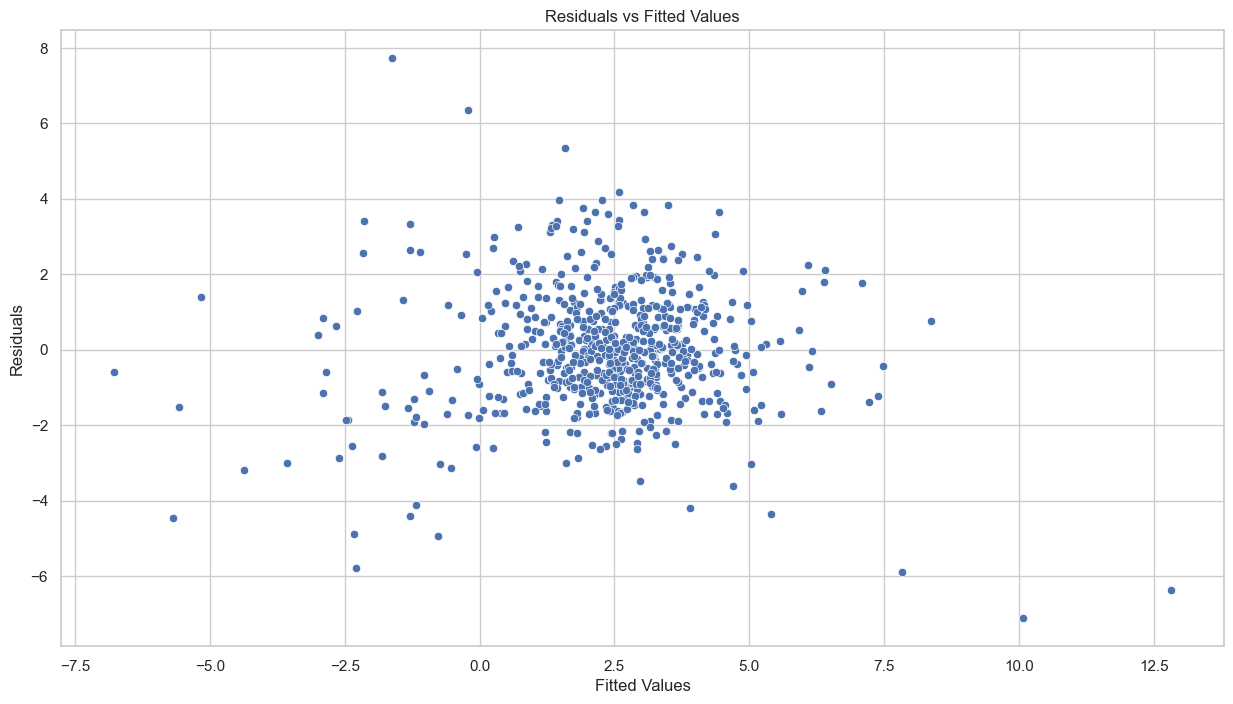

In [307]:
# Plot residuals vs X
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.scatterplot(x=pooled_ols.fittedvalues, y=pooled_ols.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

From the plot we couldn't be sure. Lets use the breusch pagan and white test to check

In [308]:
# Run breusch pagan and white heteroskedasticity test
_, pval_w, ___, f_pval_w = het_white(pooled_ols.resid, X)
_, pval_bp, ___, f_pval_bp = het_breuschpagan(pooled_ols.resid, X)

print('White Heteroskedasticity Test p-value: ', pval_w)
print('White Heteroskedasticity Test F-statistic p-value: ', f_pval_w)

print('Breusch Pagan Heteroskedasticity Test p-value: ', pval_bp)
print('Breusch Pagan Heteroskedasticity Test F-statistic p-value: ', f_pval_bp)

White Heteroskedasticity Test p-value:  6.584615943120059e-28
White Heteroskedasticity Test F-statistic p-value:  6.757442140834793e-32
Breusch Pagan Heteroskedasticity Test p-value:  0.00019714392697758073
Breusch Pagan Heteroskedasticity Test F-statistic p-value:  0.00017933884339390064


- Clearly there is heteroskedasticity -> Gauss-Markov assumptions are violated -> OLS isnt the BLUE
- Are the residuals correlated with the endogenous variable? Lets visually inspect (exogeneity)

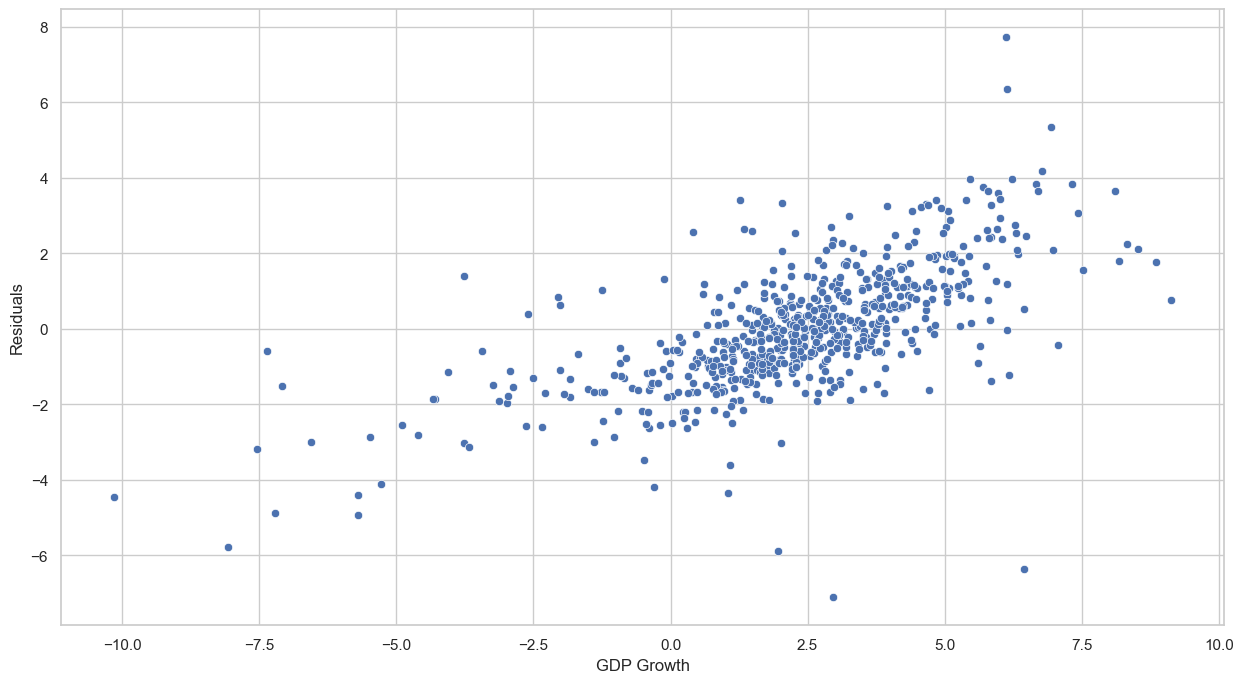

In [309]:
# Scatterplot of residuals vs gdp growth
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.scatterplot(x=data_inf_capped['GDP Growth'], y=pooled_ols.resid)
plt.xlabel('GDP Growth')
plt.ylabel('Residuals')
plt.show()

Are residuals autocorrelated?

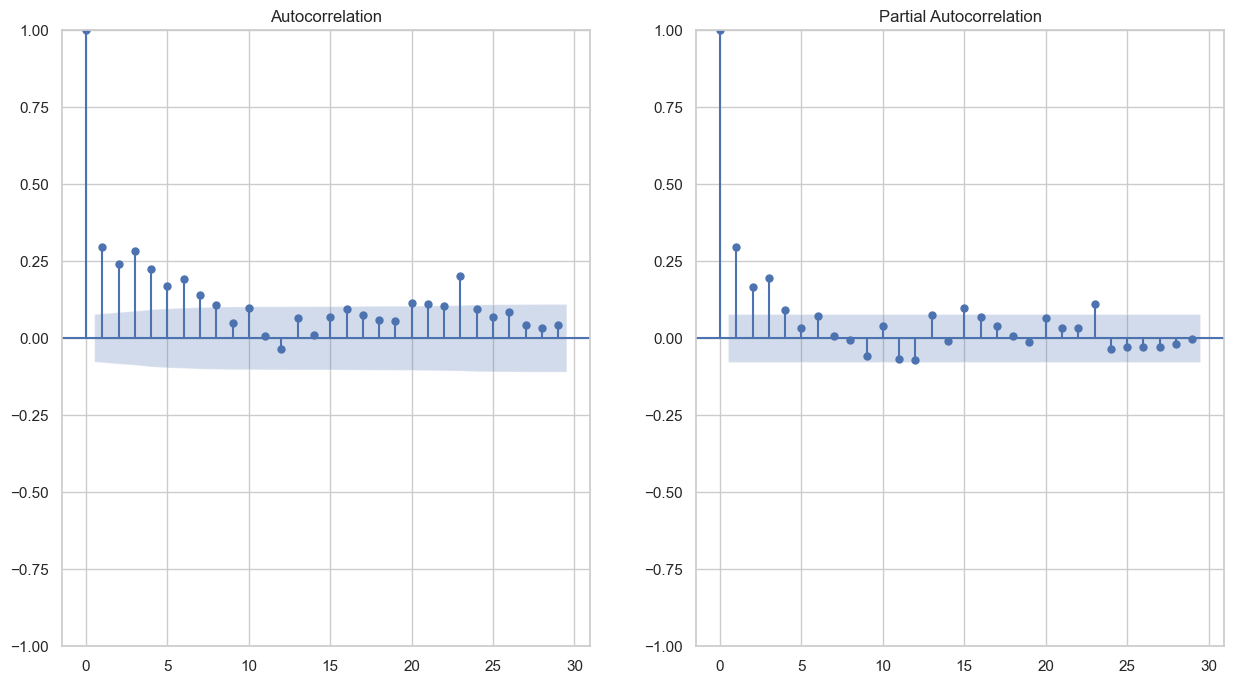

In [310]:
# Check for autocorrelation of the residuals
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,8), nrows=1, ncols=2)
tsap.plot_acf(pooled_ols.resid, ax=ax[0])
tsap.plot_pacf(pooled_ols.resid, ax=ax[1])
ax[0].set_title('Autocorrelation')
ax[1].set_title('Partial Autocorrelation')
plt.show()

Definetely autocorrelation. Lets move on to the fixed effects estimator. Why the errors? 

## Fixed Effects

In [311]:
X_fe = data_inf_capped[['GFCF change','Unemployment change','Inflation change']].copy()
y = data_inf_capped['GDP Growth']

# Add the country name to the X
X_fe['Country'] = X_fe.index

# Create dummy variables for the countries
X_fe = pd.get_dummies(X_fe, columns=['Country'], drop_first=False)

# Remove country Germany
X_fe = X_fe.drop('Country_Germany', axis=1)

# Remove Country_ from columns
X_fe.columns = [col.replace('Country_', '') for col in X_fe.columns]

# Change True and False to 1 and 0
X_fe = X_fe.replace(True, 1)
X_fe = X_fe.replace(False, 0)

# Add constant to X
X_fe = sm.add_constant(X_fe)

In [312]:
# Fit the model 
fixed_effects = sm.OLS(y, X_fe).fit()

# Print summary table
print(fixed_effects.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     42.49
Date:                Sat, 13 Jan 2024   Prob (F-statistic):          8.23e-129
Time:                        17:13:39   Log-Likelihood:                -1133.6
No. Observations:                 644   AIC:                             2329.
Df Residuals:                     613   BIC:                             2468.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0725    

In [313]:
results_fe = pd.DataFrame({'Coefficients': fixed_effects.params, 'p-value': fixed_effects.pvalues})
results_fe = results_fe.drop(['const', 'GFCF change', 'Unemployment change', 'Inflation change'], axis=0)
results_fe['c_i'] = results_fe['Coefficients'] + fixed_effects.params['const']
results_fe['Significant'] = results_fe['p-value'].apply(lambda x: '***' if x <= 0.001 else '**' if x <= 0.01 else '*' if x <= 0.05 else 'ns')
results_fe

,Coefficients,p-value,c_i,Significant
Australia,1.255471,3.338186e-03,2.327954,**
Austria,0.418716,3.253802e-01,1.491199,ns
Belgium,0.270056,5.257972e-01,1.342538,ns
Canada,0.717443,9.238481e-02,1.789926,ns
Croatia,0.403193,3.442281e-01,1.475675,ns
Cyprus,1.505826,4.452340e-04,2.578309,***
Denmark,0.028228,9.471311e-01,1.100711,ns
Finland,0.426877,3.159162e-01,1.499360,ns
France,0.108947,7.979239e-01,1.181430,ns
Greece,0.020502,9.616414e-01,1.092985,ns


Comparing pooled ols with fixed effects
- Using AIC instead of BIC because the FE has obviously more parameters (57 dummies) than the pooled ols and BIC penalizes model complexity more than AIC

In [314]:
# Compare pooled OLS and fixed effects, generate table with log likelihoods, AIC and adjusted R-squared
# Create a table with the results
results = pd.DataFrame({'Pooled OLS': [pooled_ols.llf, pooled_ols.aic, pooled_ols.rsquared_adj],
                        'Fixed Effects': [fixed_effects.llf, fixed_effects.aic, fixed_effects.rsquared_adj]},
                       index=['Log Likelihood', 'AIC', 'Adjusted R-squared'])
results

,Pooled OLS,Fixed Effects
Log Likelihood,-1225.322648,-1133.597749
AIC,2458.645297,2329.195498
Adjusted R-squared,0.566239,0.659390


In [315]:
# Run F-test to compare the models
ssr_UR = fixed_effects.ssr
ssr_R = pooled_ols.ssr
df_UR = fixed_effects.df_resid
df_R = pooled_ols.df_resid
F = ((ssr_R - ssr_UR) / (df_R - df_UR)) / (ssr_UR / df_UR)
pval = st.f.sf(F, df_R - df_UR, df_UR)
print('F-statistic: ', F)
print('p-value: ', pval)

F-statistic:  7.4825910576762125
p-value:  3.40083285608994e-24


Definetely better than pooled ols!

## Random Effects

In [357]:
# Calculating group means
group_means = data_inf_capped.copy()
group_means['Country'] = group_means.index
group_means = group_means.groupby('Country').mean()
group_means = group_means.drop('Year', axis=1)
group_means.head(5)

,GDP Growth,GFCF change,Inflation change,Unemployment change
Country,,,,
Australia,3.137464,4.118847,-0.043679,-0.145652
Austria,1.808230,1.668902,-0.014351,-0.031348
Belgium,1.900219,2.650930,-0.027835,-0.179261
Canada,2.467991,3.261513,0.016467,-0.170870
Croatia,2.161174,3.629507,-0.153399,-0.133174


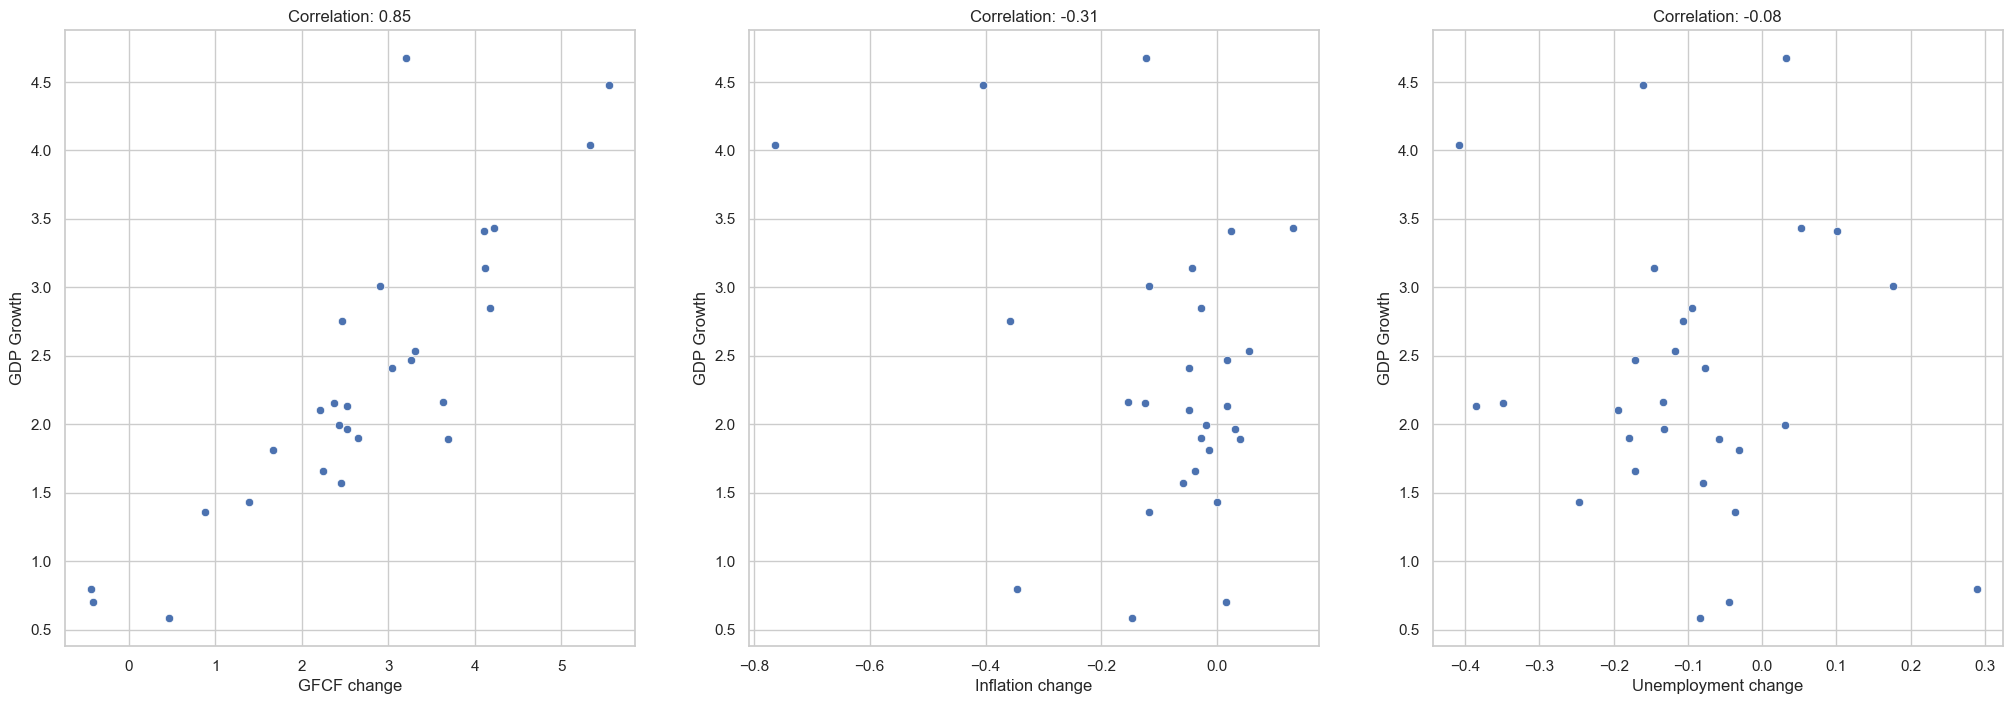

In [317]:
# Plot the group means vs GDP Growth
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(25,8))
sns.scatterplot(x="GFCF change", y="GDP Growth", data=group_means, ax=axs[0])
sns.scatterplot(x="Inflation change", y="GDP Growth", data=group_means, ax=axs[1])
sns.scatterplot(x="Unemployment change", y="GDP Growth", data=group_means, ax=axs[2])
corrs = group_means.corr().round(2)
for i in range(len(axs)):
    axs[i].set_title('Correlation: ' + str(corrs.iloc[0, i+1]))
    axs[i].set_ylabel('GDP Growth')
plt.show()

In [363]:
# Lets calculate the Random Effects model
sigma_eps = fixed_effects.mse_resid
sigma_pooled = pooled_ols.mse_resid
sigma_u = sigma_pooled - sigma_eps

theta = 1 - np.sqrt(sigma_eps / (sigma_u * data_inf_capped['Year'].nunique() + sigma_eps))

data_random_effects = data_inf_capped.copy()
data_random_effects['Country'] = data_random_effects.index
data_random_effects = data_random_effects - theta * data_random_effects.groupby('Country').transform('mean')
data_random_effects = data_random_effects.drop(['Year', 'Country'], axis=1)
data_random_effects

,GDP Growth,GFCF change,Inflation change,Unemployment change
Country Name,,,,
Australia,1.937738,4.044848,-2.362995,-0.050293
Australia,2.687801,7.142289,0.662749,-0.591293
Australia,3.052196,1.847053,0.650497,-0.716293
Australia,1.946067,5.500460,3.001807,-0.496293
Australia,0.049676,-10.537393,-0.022798,0.550707
...,...,...,...,...
United States,1.189151,1.734474,-1.472963,-0.839217
United States,0.150254,0.211107,1.173589,-0.362217
United States,0.724703,1.924431,0.899160,-0.465217


In [364]:
y = data_random_effects['GDP Growth']
X = data_random_effects[['GFCF change','Unemployment change', 'Inflation change']]

# Add constant to X
X = sm.add_constant(X)

# Fit OLS
random_effects = sm.OLS(y, X).fit()

# Print summary table
print(random_effects.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     322.7
Date:                Sat, 13 Jan 2024   Prob (F-statistic):          1.39e-127
Time:                        17:32:59   Log-Likelihood:                -1148.2
No. Observations:                 644   AIC:                             2304.
Df Residuals:                     640   BIC:                             2322.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6708    

Lets test the significance of the random effects

In [ ]:
# MISSING 

Comparison of the models

In [365]:
# Compare pooled OLS and random effects, generate table with log likelihoods, AIC and adjusted R-squared
# Create a table with the results
results = pd.DataFrame({'Pooled OLS': [pooled_ols.llf, pooled_ols.aic, pooled_ols.rsquared_adj],
                        'Fixed Effects': [fixed_effects.llf, fixed_effects.aic, fixed_effects.rsquared_adj],
                        'Random Effects': [random_effects.llf, random_effects.aic, random_effects.rsquared_adj]},
                       index=['Log Likelihood', 'AIC', 'Adjusted R-squared'])
results

,Pooled OLS,Fixed Effects,Random Effects
Log Likelihood,-1225.322648,-1133.597749,-1148.214554
AIC,2458.645297,2329.195498,2304.429108
Adjusted R-squared,0.566239,0.659390,0.600181
